***Week 2 Progress***

In [1]:
import os
os.chdir('..')
print("Current working directory:", os.getcwd())

Current working directory: /home/eduardburlacu/master/TargSpEx


In [2]:
import torch
from huggingface_hub import hf_hub_download
from src.models.facodec import FACodecEncoder,FACodecDecoder


fac_encoder = FACodecEncoder(
    ngf=32,
    up_ratios=[2, 4, 5, 5],
    out_channels=256,
)
fac_decoder = FACodecDecoder(
    in_channels=256,
    upsample_initial_channel=1024,
    ngf=32,
    up_ratios=[5, 5, 4, 2],
    vq_num_q_c=2,
    vq_num_q_p=1,
    vq_num_q_r=3,
    vq_dim=256,
    codebook_dim=8,
    codebook_size_prosody=10,
    codebook_size_content=10,
    codebook_size_residual=10,
    use_gr_x_timbre=True,
    use_gr_residual_f0=True,
    use_gr_residual_phone=True,
)

encoder_ckpt = hf_hub_download(repo_id="amphion/naturalspeech3_facodec", filename="ns3_facodec_encoder.bin")
decoder_ckpt = hf_hub_download(repo_id="amphion/naturalspeech3_facodec", filename="ns3_facodec_decoder.bin")
fac_encoder.load_state_dict(torch.load(encoder_ckpt))
fac_encoder.eval()
fac_decoder.load_state_dict(torch.load(decoder_ckpt))
fac_decoder.eval()

/home/eduardburlacu/.local/lib/python3.10/site-packages/torch/nn/utils/weight_norm.py:143: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)
/tmp/ipykernel_817610/4099867309.py:31: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True

FACodecDecoder(
  (quantizer): ModuleList(
    (0): ResidualVQ(
      (layers): ModuleList(
        (0): FactorizedVectorQuantize(
          (in_proj): Linear(in_features=256, out_features=8, bias=True)
          (out_proj): Linear(in_features=8, out_features=256, bias=True)
          (_codebook): Embedding(1024, 8)
        )
      )
    )
    (1): ResidualVQ(
      (layers): ModuleList(
        (0-1): 2 x FactorizedVectorQuantize(
          (in_proj): Linear(in_features=256, out_features=8, bias=True)
          (out_proj): Linear(in_features=8, out_features=256, bias=True)
          (_codebook): Embedding(1024, 8)
        )
      )
    )
    (2): ResidualVQ(
      (layers): ModuleList(
        (0-2): 3 x FactorizedVectorQuantize(
          (in_proj): Linear(in_features=256, out_features=8, bias=True)
          (out_proj): Linear(in_features=8, out_features=256, bias=True)
          (_codebook): Embedding(1024, 8)
        )
      )
    )
  )
  (model): Sequential(
    (0): Conv1d(256, 

In [3]:
import librosa
import torch
import soundfile as sf

In [4]:
test_wav_path = os.path.abspath(os.path.join(".","assets/facodec/1.wav"))
print(test_wav_path)

/home/eduardburlacu/master/TargSpEx/assets/facodec/1.wav


In [5]:
test_wav = librosa.load(test_wav_path, sr=16_000)[0]
test_wav = torch.from_numpy(test_wav).float()
test_wav = test_wav.unsqueeze(0).unsqueeze(0)
test_wav.shape

torch.Size([1, 1, 125677])

In [6]:

with torch.no_grad():
    # encode
    enc_out = fac_encoder(test_wav)
    print(enc_out.shape)

    # quantize
    vq_post_emb, vq_id, _, quantized, spk_embs = fac_decoder(enc_out, eval_vq=False, vq=True)
    
    # latent after quantization
    print(vq_post_emb.shape)
    
    # codes
    print("vq id shape:", vq_id.shape)
    
    # get prosody code
    prosody_code = vq_id[:1]
    print("prosody code shape:", prosody_code.shape)
    
    # get content code
    cotent_code = vq_id[1:3]
    print("content code shape:", cotent_code.shape)
    
    # get residual code (acoustic detail codes)
    residual_code = vq_id[3:]
    print("residual code shape:", residual_code.shape)
    
    # speaker embedding
    print("speaker embedding shape:", spk_embs.shape)

    # decode (recommand)
    recon_wav = fac_decoder.inference(vq_post_emb, spk_embs)
    print(recon_wav.shape)
    sf.write("recon.wav", recon_wav[0][0].cpu().numpy(), 16000)

torch.Size([1, 256, 628])
torch.Size([1, 256, 628])
vq id shape: torch.Size([6, 1, 628])
prosody code shape: torch.Size([1, 1, 628])
content code shape: torch.Size([2, 1, 628])
residual code shape: torch.Size([3, 1, 628])
speaker embedding shape: torch.Size([1, 256])
torch.Size([1, 1, 125600])


Now we will do the same over a subset of LibriMix.
Before that, we will need some helper functions to resample the audio files to 16kHz and iterate over the dataset.

In [7]:
def get_sampling_rate(file_path):
    # Load the audio file with librosa, sr=None to keep the original sampling rate
    y, sr = librosa.load(file_path, sr=None)
    
    # Return the sampling rate
    return sr

def resample_audio_librosa(input_file, output_file, orig_sr=8000, target_sr=16000):
    # Load the audio file
    y, sr = librosa.load(input_file, sr=orig_sr)
    
    # Resample to the target sampling rate
    y_resampled = librosa.resample(y, orig_sr=orig_sr, target_sr=target_sr)
    
    # Save the resampled audio
    sf.write(output_file, y_resampled, target_sr)


In [9]:
from asteroid.data import LibriMix

train_set, val_set = LibriMix.mini_from_download(task='sep_clean')

ValueError: numpy.dtype size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject

In [8]:
get_sampling_rate("MiniLibriMix/train/mix_both/14-212-0013_7926-254949-0054.wav")
debug = False

/tmp/ipykernel_817610/1438751116.py:3: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(file_path, sr=None)
/home/eduardburlacu/.local/lib/python3.10/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


FileNotFoundError: [Errno 2] No such file or directory: 'MiniLibriMix/train/mix_both/14-212-0013_7926-254949-0054.wav'

In [60]:
from asteroid.data import LibriMix
# This will automatically download MiniLibriMix from Zenodo on the first run.
train_loader, val_loader = LibriMix.loaders_from_mini(task="sep_clean", batch_size=1)  

Drop 0 utterances from 800 (shorter than 3 seconds)
Drop 0 utterances from 200 (shorter than 3 seconds)


In [61]:
print(train_loader.dataset[0][0].shape,train_loader.dataset[0][1].shape)
print(len(train_loader))

torch.Size([24000]) torch.Size([2, 24000])
800


In [62]:
from torchaudio.transforms import Resample
orig_sr = 8_000
target_sr = 16_000
resampler = Resample(orig_freq=orig_sr, new_freq=target_sr)

In [70]:
import numpy as np
with torch.no_grad():
    z_1_np = []
    z_2_np = []
    z_mix_np =[]
    for idx, (mix, sources) in enumerate(train_loader):
        mix_dim = mix.shape
        mix = resampler(mix).unsqueeze(1) #add channel dimension
        s1, s2 = sources.split(1, dim=1)
        if idx==0:
            print(F"Shapes before resampling: {mix_dim}, {s1.shape}, {s2.shape}")
        s1 = resampler(s1)
        s2 = resampler(s2)
        if idx==0:
            print(F"Shapes after resampling: {mix.shape}, {s1.shape}, {s2.shape}")
        z_mix = fac_encoder(mix)
        z_1 = fac_encoder(s1)
        z_2 = fac_encoder(s2)
        if idx==0:
            print(F"Shapes in latent space encoding: {z_mix.shape}, {z_1.shape}, {z_2.shape}")
        z_1_np.append(z_1.cpu())
        z_2_np.append(z_2.cpu())
        z_mix_np.append(z_mix.cpu()) 

Shapes before resampling: torch.Size([1, 24000]), torch.Size([1, 1, 24000]), torch.Size([1, 1, 24000])
Shapes after resampling: torch.Size([1, 1, 48000]), torch.Size([1, 1, 48000]), torch.Size([1, 1, 48000])
Shapes in latent space encoding: torch.Size([1, 256, 240]), torch.Size([1, 256, 240]), torch.Size([1, 256, 240])


In [96]:
def get_quantized_latent(enc_out_list:list):
    latents = [None]*len(enc_out_list)
    spk_emb = [None]*len(enc_out_list)
    for i, enc_out in enumerate(enc_out_list):
        with torch.no_grad():
            # quantize
            latents[i], _, _, _, spk_emb[i] = fac_decoder(enc_out, eval_vq=False, vq=True)
    return latents, spk_emb

In [99]:
z_q1, spk_emb_1 = get_quantized_latent(z_1_np)
z_q2, spk_emb_2 = get_quantized_latent(z_2_np)
z_qmix, spk_emb_mix = get_quantized_latent(z_mix_np)

In [100]:
# latent after quantization
print("quantized latent shape:",z_q1[0].shape)        
# speaker embedding
print("speaker embedding shape:", spk_emb_1[0].shape)

# Convert lists to numpy arrays for easier manipulation
spk_emb_1 = np.array([emb.squeeze(0).cpu().numpy() for emb in spk_emb_1])
spk_emb_2 = np.array([emb.squeeze(0).cpu().numpy() for emb in spk_emb_2])
spk_emb_mix = np.array([emb.squeeze(0).cpu().numpy() for emb in spk_emb_mix])
z_q1 = np.array([latent.squeeze(0).cpu().numpy() for latent in z_q1])
z_q2 = np.array([latent.squeeze(0).cpu().numpy() for latent in z_q2])
z_qmix = np.array([latent.squeeze(0).cpu().numpy() for latent in z_qmix])

# latent after quantization
print("quantized latent shape:",z_q1[0].shape)        
# speaker embedding
print("speaker embedding shape:", spk_emb_1[0].shape)

quantized latent shape: torch.Size([1, 256, 240])
speaker embedding shape: torch.Size([1, 256])
quantized latent shape: (256, 240)
speaker embedding shape: (256,)


In [102]:
print(z_q1.shape)
print(spk_emb_1.shape)

(800, 256, 240)
(800, 256)


In [103]:
import matplotlib.pyplot as plt  
%matplotlib inline               

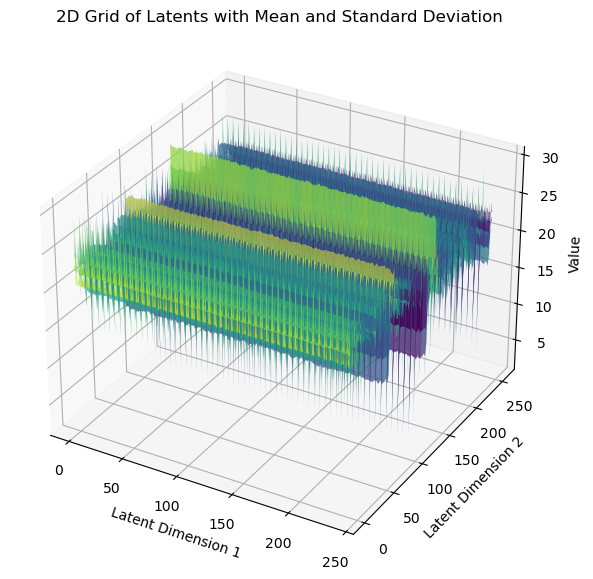

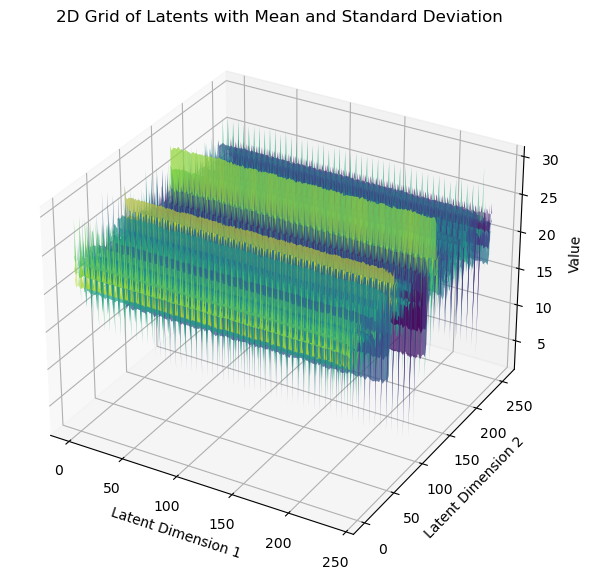

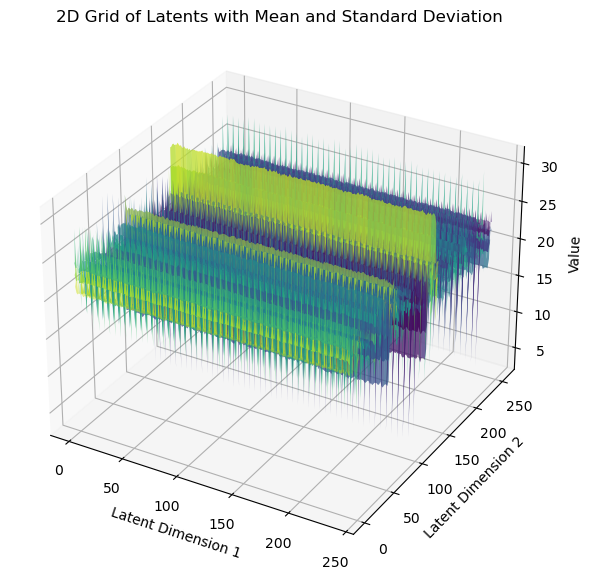

In [110]:
def plot_latent(latents:np.array):
    # Assuming latents is a numpy array of shape (speaker, latent1, latent2)
    latents_mean = np.mean(latents, axis=0)
    latents_std = np.std(latents, axis=0)
    
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')
    
    x = np.arange(latents_mean.shape[1])
    y = np.arange(latents_mean.shape[0])
    x, y = np.meshgrid(x, y)
    
    ax.plot_surface(x, y, latents_mean, alpha=0.75, cmap='viridis')
    ax.plot_surface(x, y, latents_mean + latents_std, alpha=0.5, cmap='viridis')
    ax.plot_surface(x, y, latents_mean - latents_std, alpha=0.5, cmap='viridis')
    
    ax.set_title('2D Grid of Latents with Mean and Standard Deviation')
    ax.set_xlabel('Latent Dimension 1')
    ax.set_ylabel('Latent Dimension 2')
    ax.set_zlabel('Value')
    plt.show()
plot_latent(z_q1)
plot_latent(z_q2)
plot_latent(z_qmix)

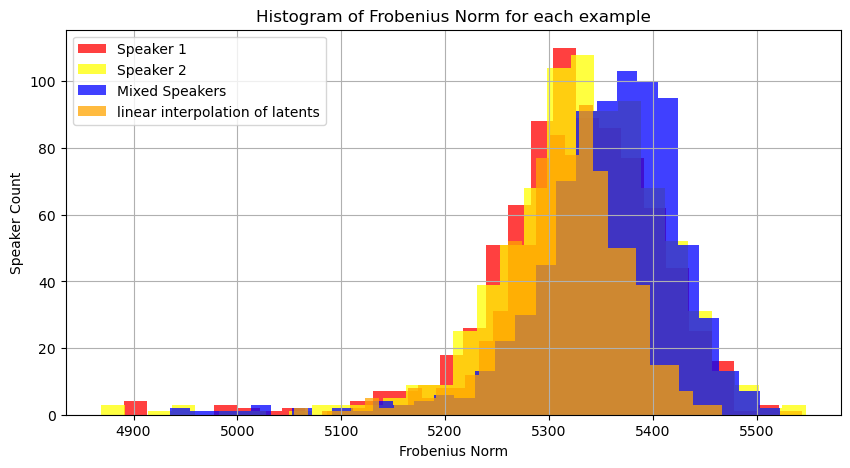

In [148]:
def plot_frobenius_histogram(latents:np.array, label:str, color:str):
    latents_frobenius = np.linalg.norm(latents, ord='fro', axis=(1, 2))
    plt.hist(latents_frobenius, bins=30, alpha=0.75, color=color, label=label)
def plot_std(latents:np.array, label:str, color:str):
    latents_std = np.std(latents, axis=(1,2))
    plt.hist(latents_std, bins=30, alpha=0.75, color=color, label=label, density=True)
plt.figure(figsize=(10, 5))
plot_frobenius_histogram(z_q1, "Speaker 1", color='red')
plot_frobenius_histogram(z_q2, "Speaker 2", color = 'yellow')
plot_frobenius_histogram(z_qmix, "Mixed Speakers", color = 'blue')
plot_frobenius_histogram((z_q1 + z_q2) / 2, "linear interpolation of latents", color='orange')
plt.title(f'Histogram of Frobenius Norm for each example')
plt.xlabel('Frobenius Norm')
plt.ylabel('Speaker Count')
plt.grid(True)
plt.legend()
plt.show()

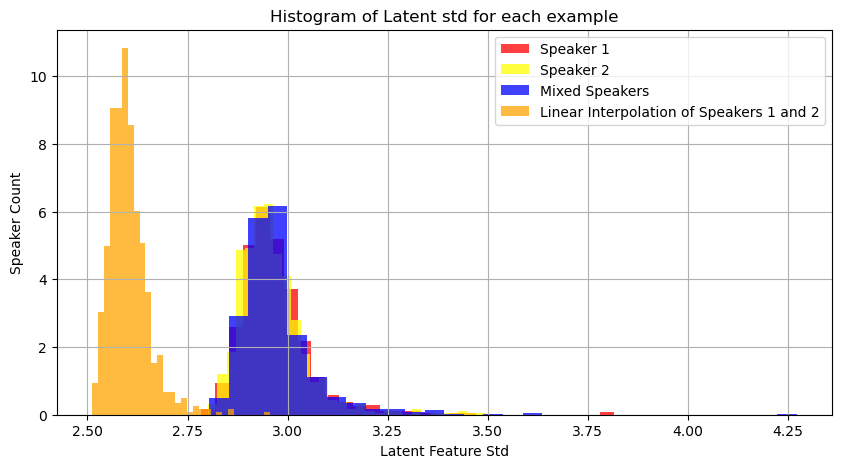

In [149]:
plt.figure(figsize=(10, 5))
plot_std(z_q1, "Speaker 1", color='red')
plot_std(z_q2, "Speaker 2", color = 'yellow')
plot_std(z_qmix, "Mixed Speakers", color = 'blue')
plot_std((z_q1 + z_q2) / 2, "Linear Interpolation of Speakers 1 and 2", color='orange')
plt.title(f'Histogram of Latent std for each example')
plt.xlabel('Latent Feature Std')
plt.ylabel('Speaker Count')
plt.grid(True)
plt.legend()
plt.show()

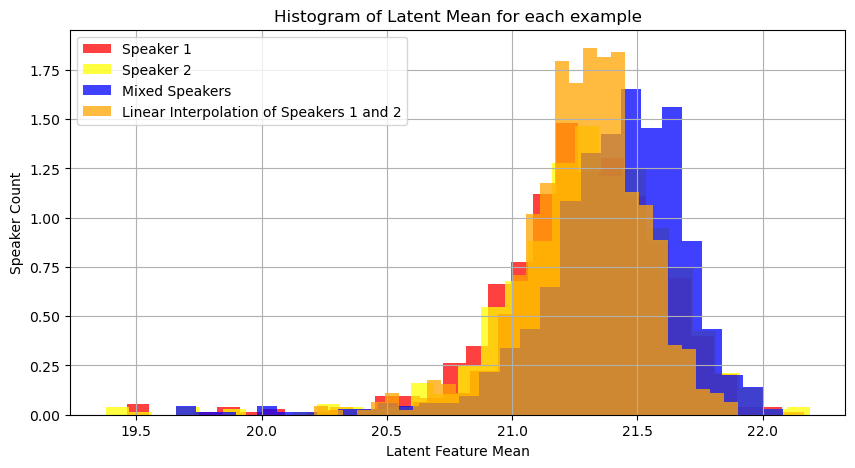

In [179]:
def plot_mean(latents:np.array, label:str, color:str):
    latents_mean = np.mean(latents, axis=(1,2))
    plt.hist(latents_mean, bins=30, alpha=0.75, color=color, label=label, density = True)
plt.figure(figsize=(10, 5))
plot_mean(z_q1, "Speaker 1", color='red')
plot_mean(z_q2, "Speaker 2", color = 'yellow')
plot_mean(z_qmix, "Mixed Speakers", color = 'blue')
plot_mean((z_q1 + z_q2) / 2, "Linear Interpolation of Speakers 1 and 2", color='orange')
plt.title(f'Histogram of Latent Mean for each example')
plt.xlabel('Latent Feature Mean')
plt.ylabel('Speaker Count')
plt.grid(True)
plt.legend()
plt.show()

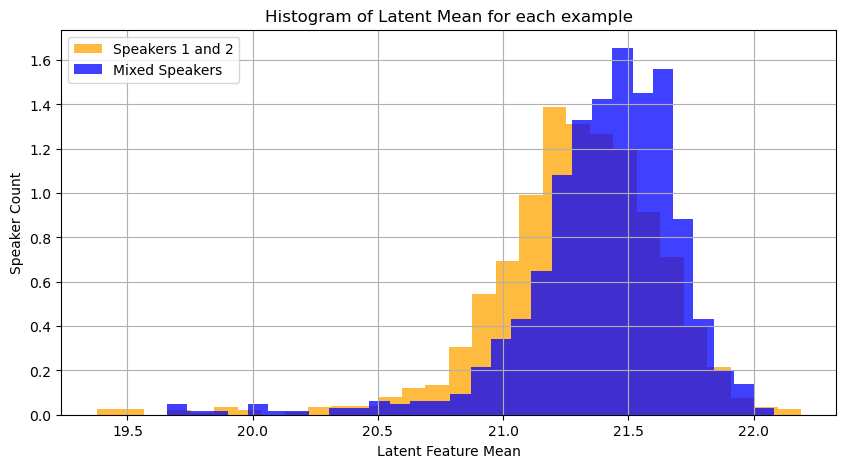

In [182]:
plt.figure(figsize=(10, 5))                                                                 
plot_mean(np.concatenate([z_q1,z_q2], axis=0), "Speakers 1 and 2", color='orange')
plot_mean(z_qmix, "Mixed Speakers", color = 'blue') 
plt.title(f'Histogram of Latent Mean for each example')                                     
plt.xlabel('Latent Feature Mean')                                                           
plt.ylabel('Speaker Count')                                                                 
plt.grid(True)                                                                              
plt.legend()                                                                                
plt.show()                                                                                  

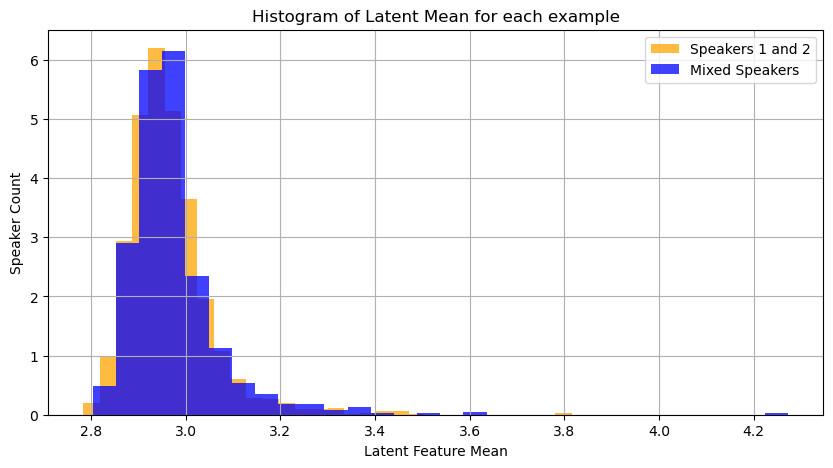

In [181]:
def plot_std(latents:np.array, label:str, color:str):
    latents_mean = np.std(latents, axis=(1,2))
    plt.hist(latents_mean, bins=30, alpha=0.75, color=color, label=label, density = True)
plt.figure(figsize=(10, 5))
plot_std(np.concatenate([z_q1,z_q2], axis=0), "Speakers 1 and 2", color='orange')
plot_std(z_qmix, "Mixed Speakers", color = 'blue')
plt.title(f'Histogram of Latent Mean for each example')
plt.xlabel('Latent Feature Mean')
plt.ylabel('Speaker Count')
plt.grid(True)
plt.legend()
plt.show()

*What happens if we do batch normalization of the features? We'll exlore this by normalizing with respect to the whole dataset.*

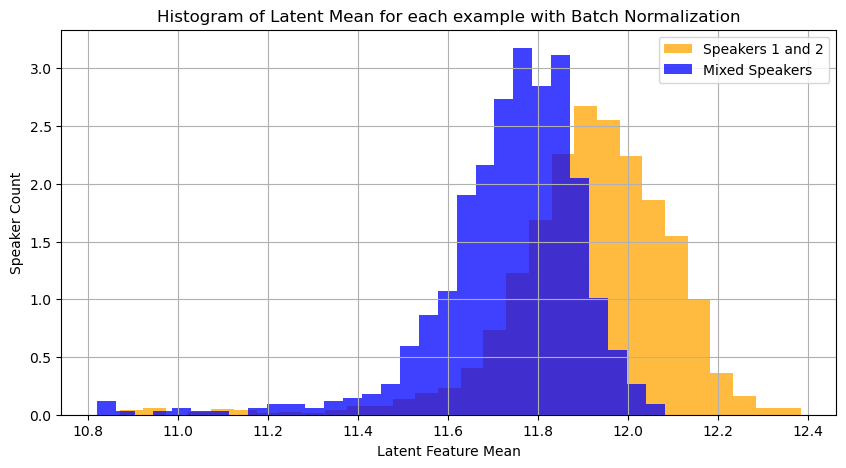

In [185]:
def plot_mean_bn(latents:np.array, label:str, color:str):
    latents_bn = latents / np.std(latents, axis=0)
    latents_mean = np.mean(latents_bn, axis=(1,2))
    plt.hist(latents_mean, bins=30, alpha=0.75, color=color, label=label, density = True)
plt.figure(figsize=(10, 5))
plot_mean_bn(np.concatenate([z_q1,z_q2], axis=0), "Speakers 1 and 2", color='orange')
plot_mean_bn(z_qmix, "Mixed Speakers", color = 'blue') 
plt.title(f'Histogram of Latent Mean for each example with Batch Normalization')
plt.xlabel('Latent Feature Mean')
plt.ylabel('Speaker Count')
plt.grid(True)
plt.legend()
plt.show()

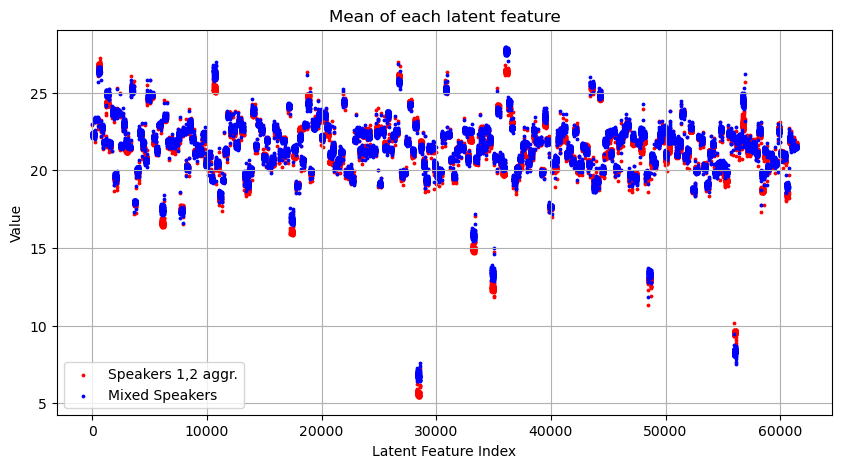

In [144]:
def plot_latent_with_error_bars(latents: np.array, label, color, ecolor):
    # Flatten the latent feature map along the 1,2 axes
    latents_flattened = latents.reshape(latents.shape[0], -1)
    
    # Compute the mean and standard deviation along axis 0
    latents_mean = np.mean(latents_flattened, axis=0)
    latents_std = np.std(latents_flattened, axis=0)
    
    # Create a scatter plot with the mean values
    x = np.arange(latents_mean.shape[0])
    plt.scatter(x, latents_mean, s=3, label=label, color=color)
    
    # Add error bars to represent the standard deviation
    #plt.fill_between(x, latents_mean - latents_std, latents_mean + latents_std, color=ecolor, alpha=0.5)
    #plt.errorbar(x, latents_mean, yerr=latents_std, fmt='o', color=ecolor, ecolor=ecolor, elinewidth=2, capsize=2)
    

# Example usage
plt.figure(figsize=(10, 5))  
plot_latent_with_error_bars(np.concatenate([z_q1, z_q2], axis=0), label="Speakers 1,2 aggr.", color='red', ecolor='salmon')
plot_latent_with_error_bars(z_qmix, label="Mixed Speakers", color='blue', ecolor='lightblue')
# Add labels and title
plt.xlabel('Latent Feature Index')
plt.ylabel('Value')
plt.title('Mean of each latent feature')
plt.legend()
plt.grid(True)
plt.show()

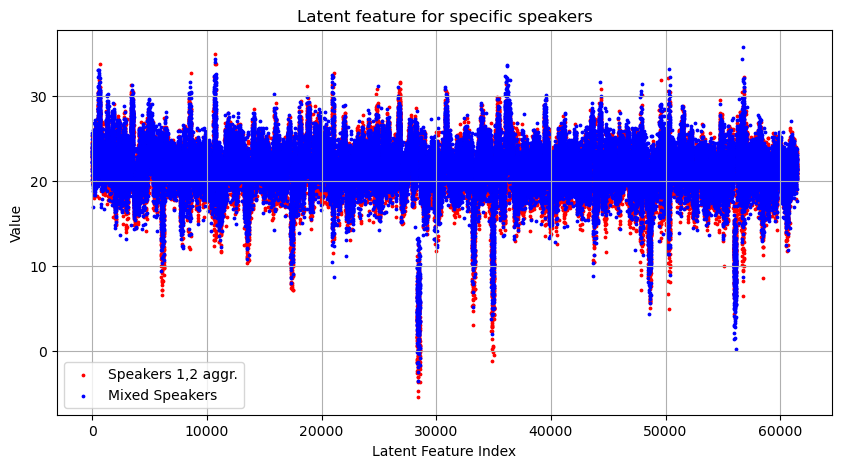

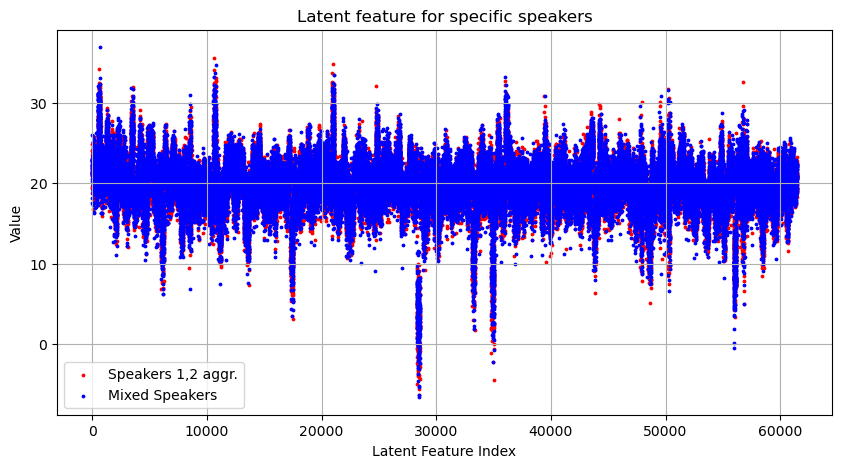

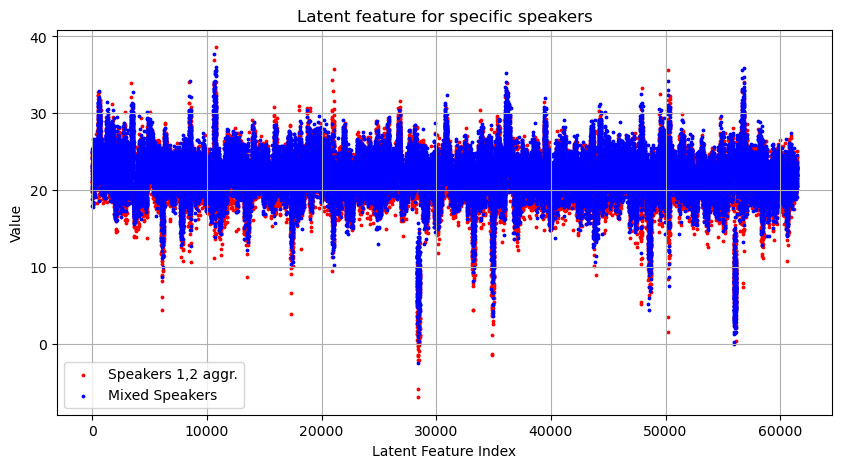

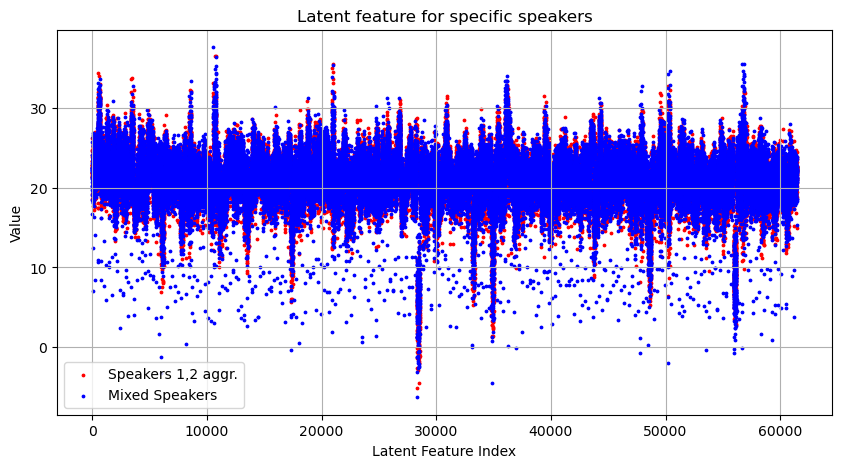

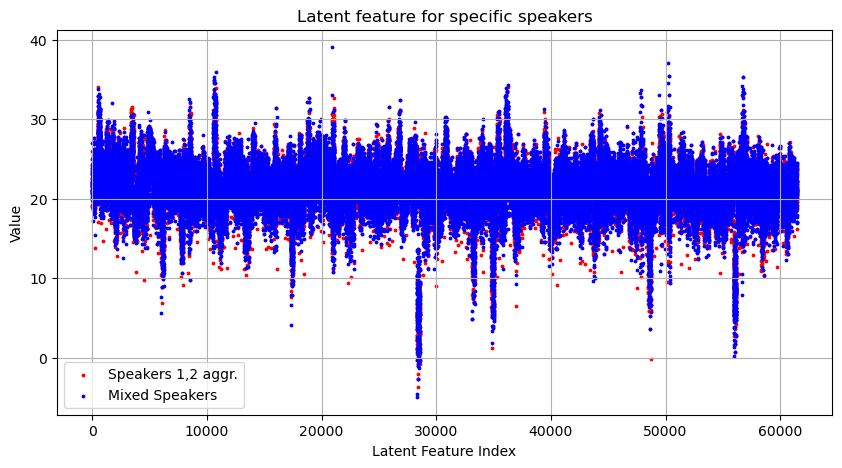

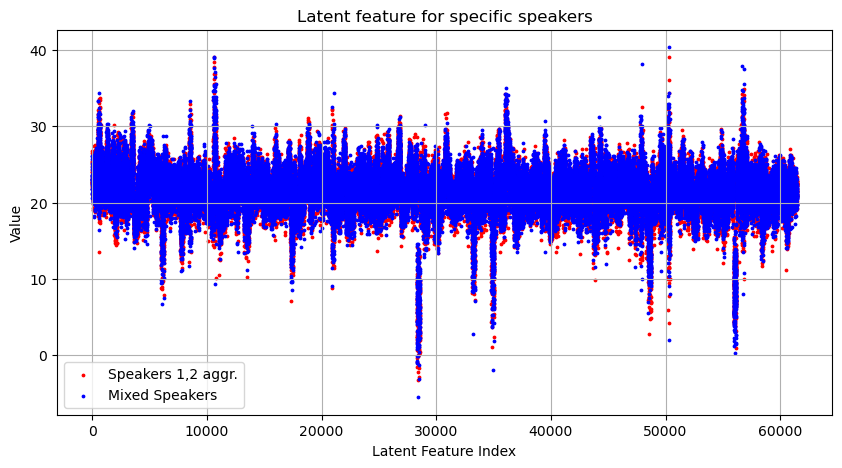

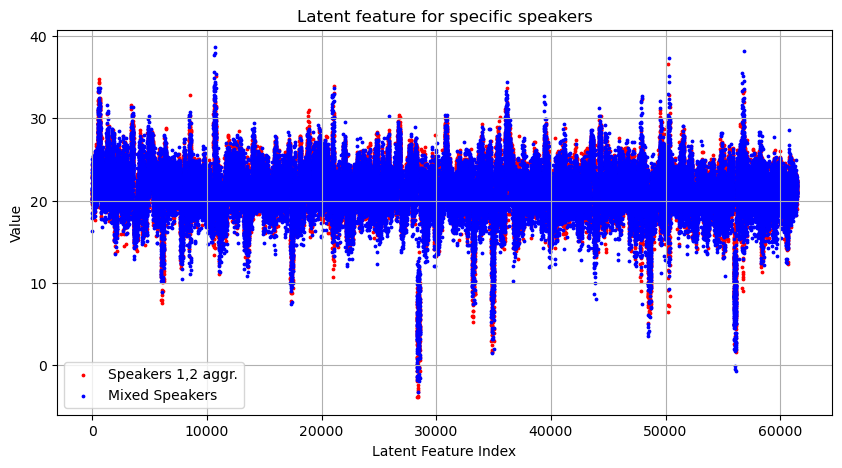

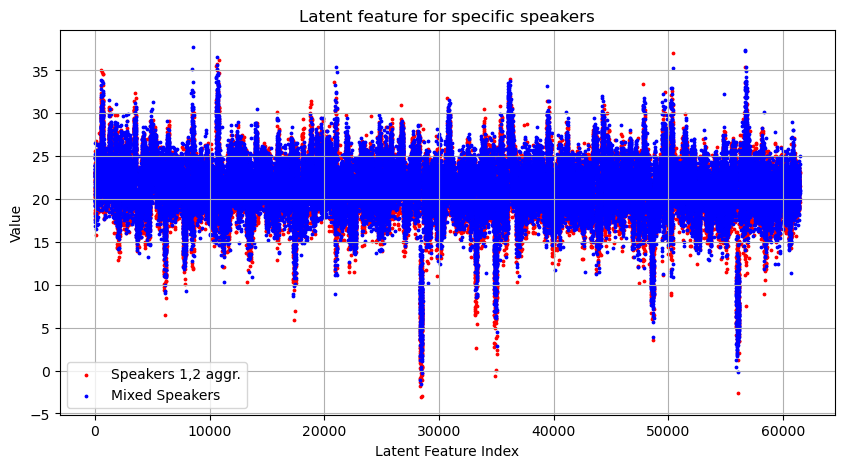

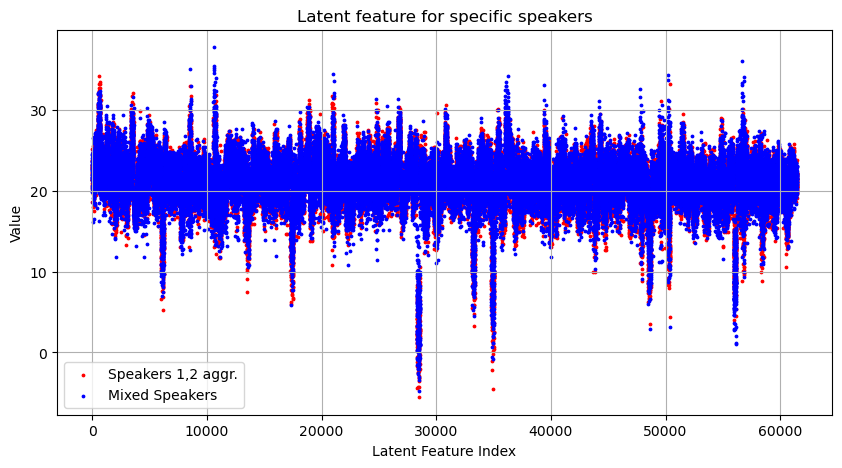

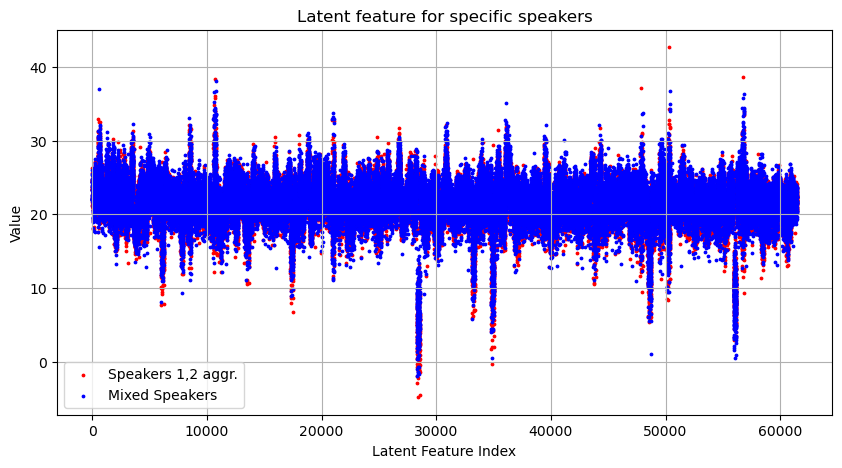

In [165]:
def plot_latent_with_error_bars(latent: np.array, label, color, ecolor):
    # Flatten the latent feature map along the 1,2 axes
    latent_flattened = latent.reshape(-1)
    
    # Create a scatter plot with the mean values
    x = np.arange(latent_flattened.shape[0])
    plt.scatter(x, latent_flattened, s=3, label=label, color=color)
z_q12 = np.concatenate([z_q1, z_q2], axis=0)
# Example usage
for i in range(10):
    plt.figure(figsize=(10, 5))  
    plot_latent_with_error_bars(z_q12[i,:,:], label="Speakers 1,2 aggr.", color='red', ecolor='salmon')
    plot_latent_with_error_bars(z_qmix[i,:,:], label="Mixed Speakers", color='blue', ecolor='lightblue')
    # Add labels and title
    plt.xlabel('Latent Feature Index')
    plt.ylabel('Value')
    plt.title('Latent feature for specific speakers')
    plt.legend()
    plt.grid(True)
    plt.show()

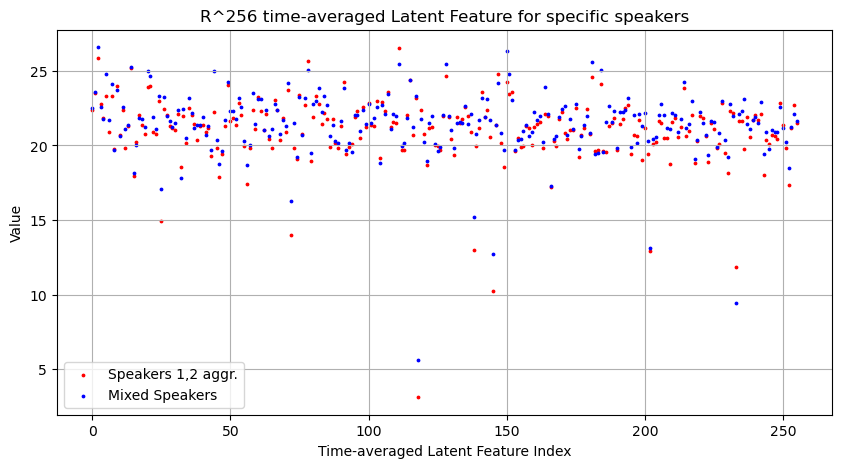

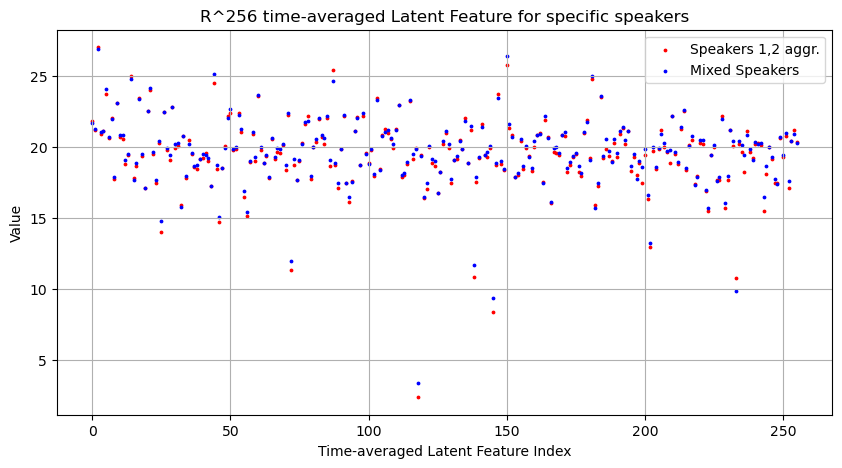

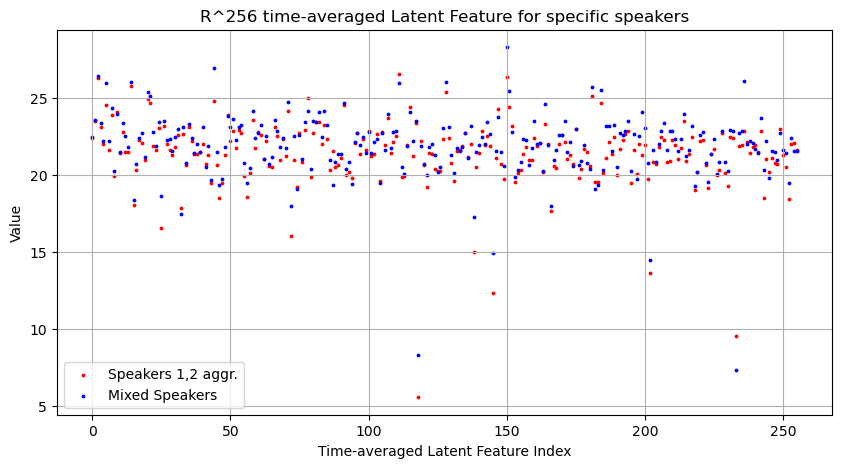

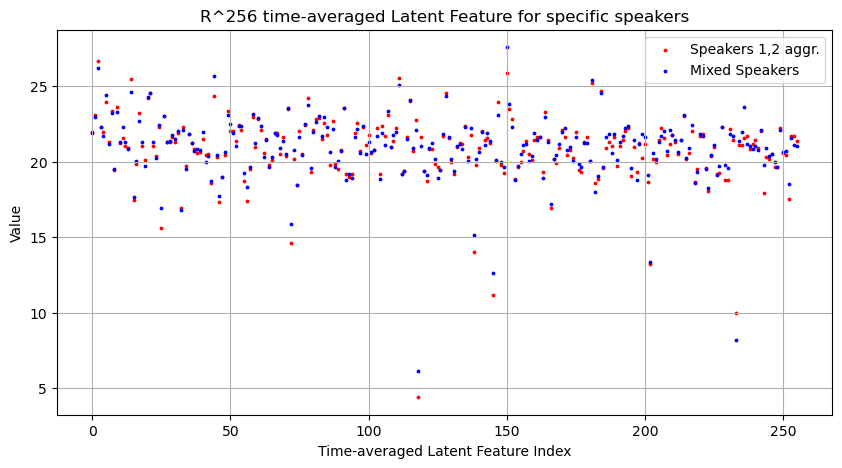

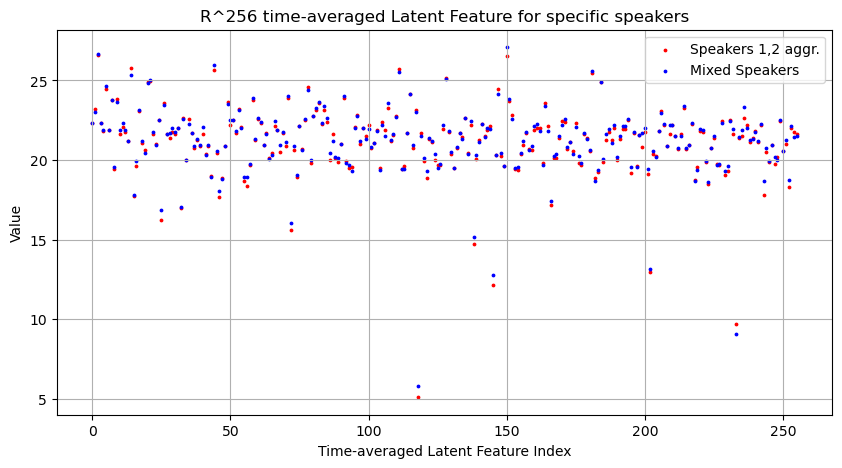

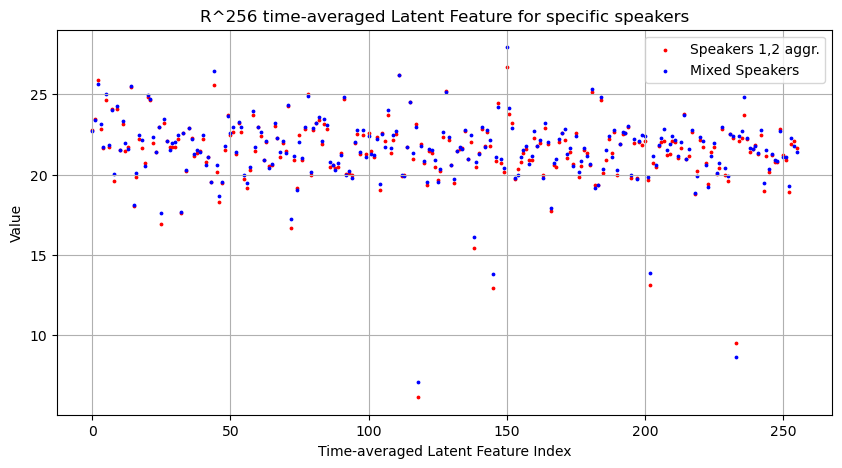

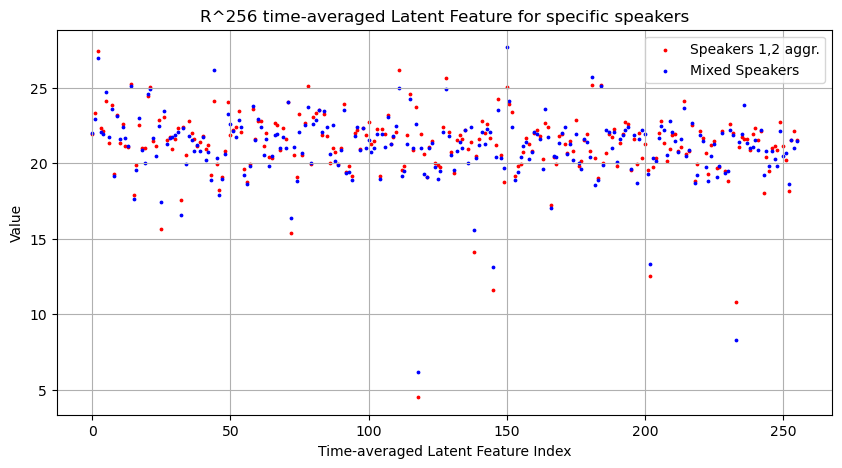

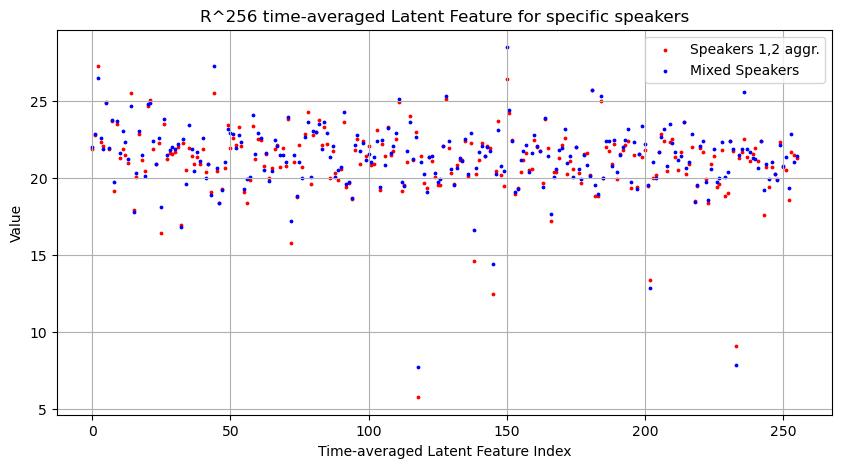

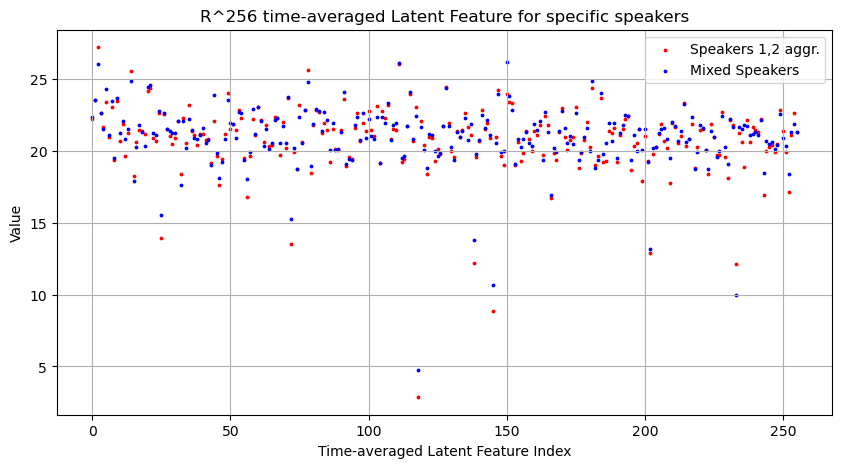

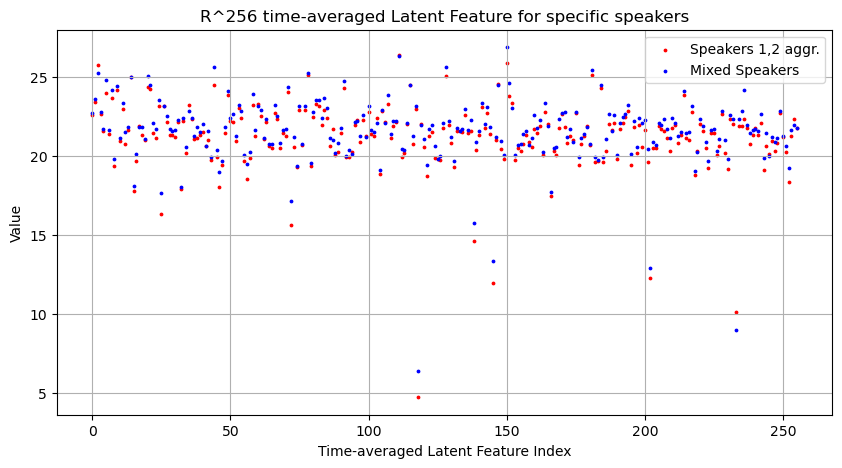

In [173]:
for i in range(10):
    plt.figure(figsize=(10, 5))  
    plot_latent_with_error_bars(np.mean(z_q12[i,:,:], axis=1), label="Speakers 1,2 aggr.", color='red', ecolor='salmon')
    plot_latent_with_error_bars(np.mean(z_qmix[i,:,:], axis=1), label="Mixed Speakers", color='blue', ecolor='lightblue')
    # Add labels and title
    plt.xlabel('Time-averaged Latent Feature Index')
    plt.ylabel('Value')
    plt.title('R^256 time-averaged Latent Feature for specific speakers')
    plt.legend()
    plt.grid(True)
    plt.show()

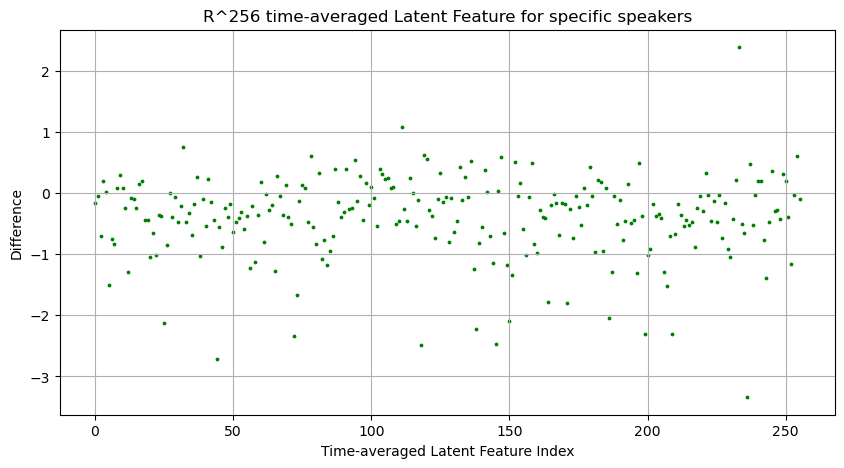

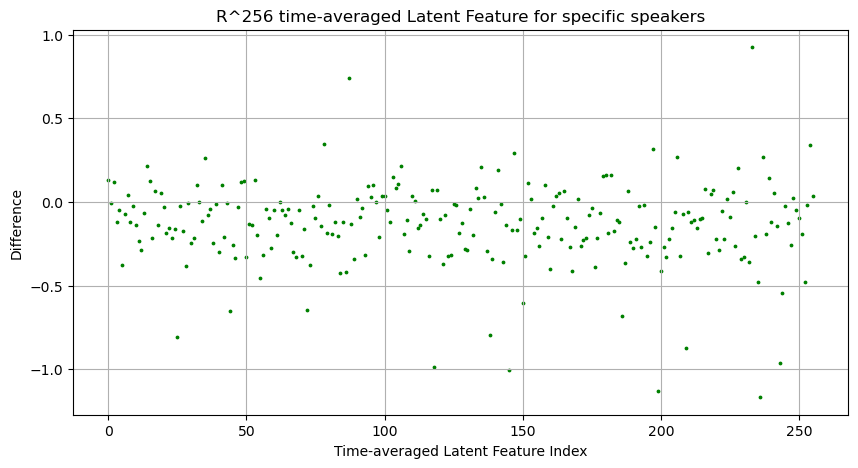

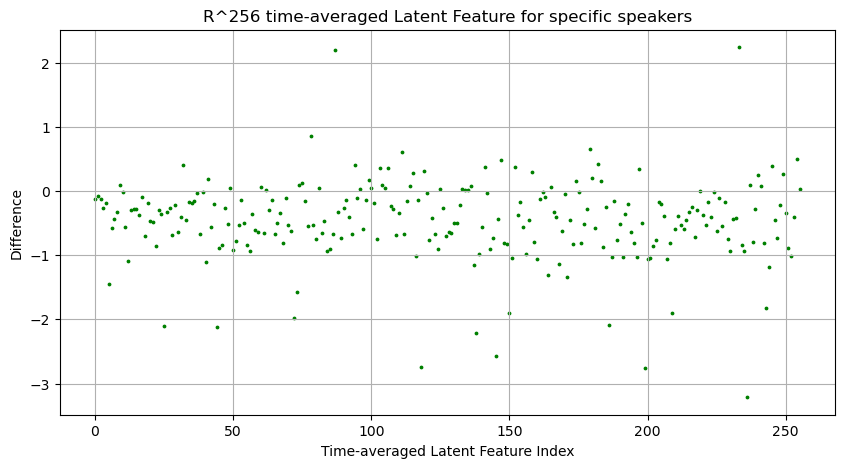

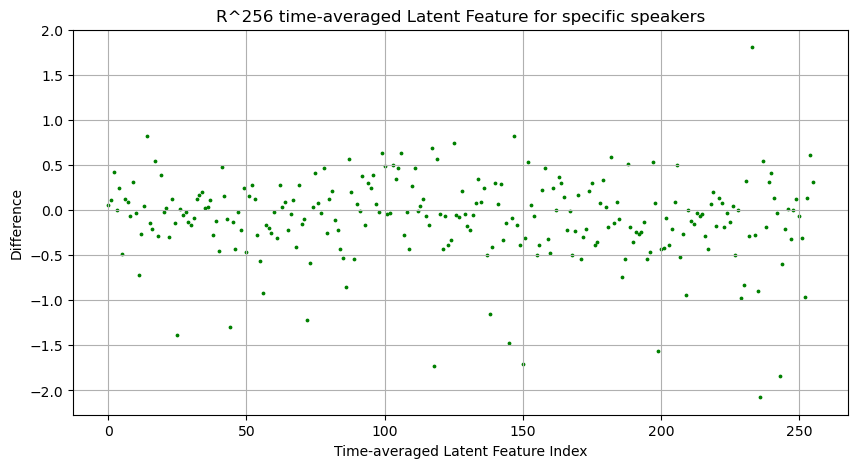

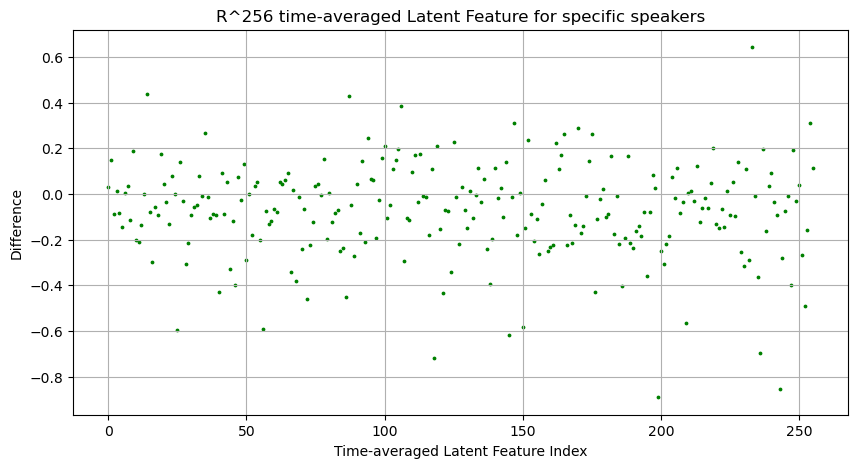

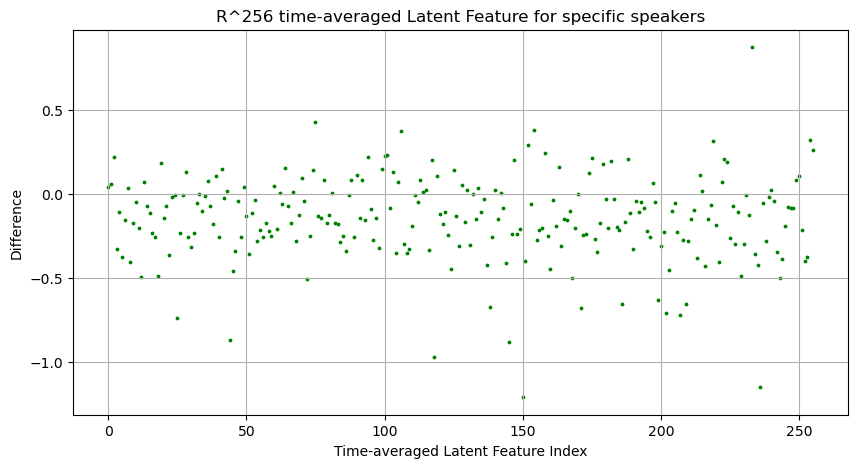

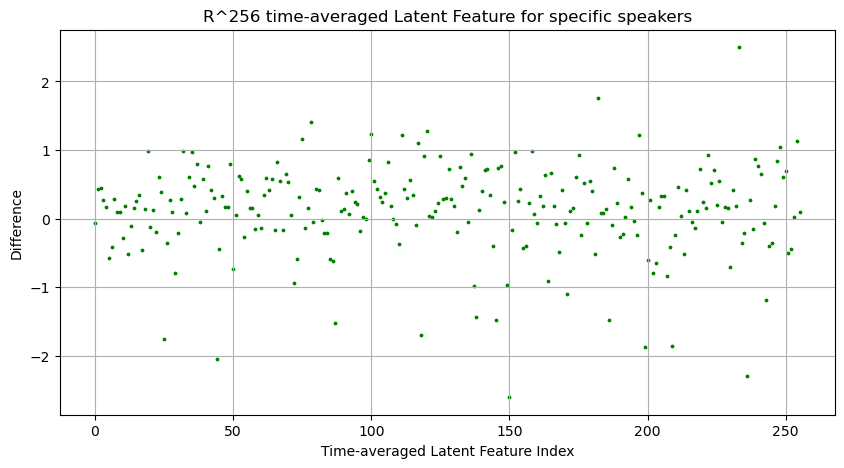

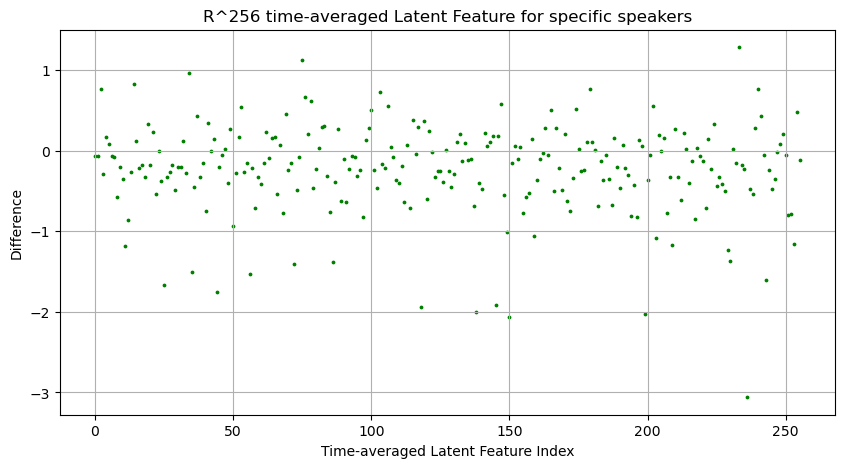

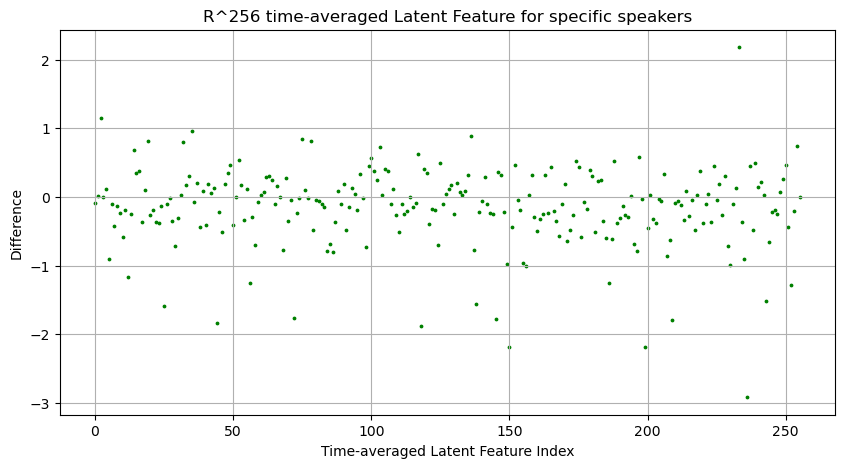

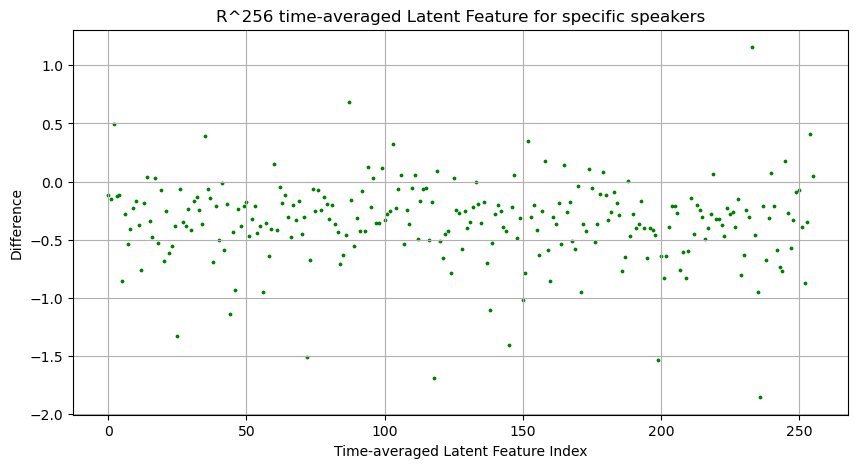

In [174]:
for i in range(10):
    plt.figure(figsize=(10, 5))  
    plot_latent_with_error_bars(np.mean(z_q12[i,:,:], axis=1) - np.mean(z_qmix[i,:,:], axis=1), color='green', ecolor='lightgreen', label='')
    # Add labels and title
    plt.xlabel('Time-averaged Latent Feature Index')
    plt.ylabel('Difference')
    plt.title('R^256 time-averaged Latent Feature for specific speakers')
    plt.grid(True)
    plt.show()

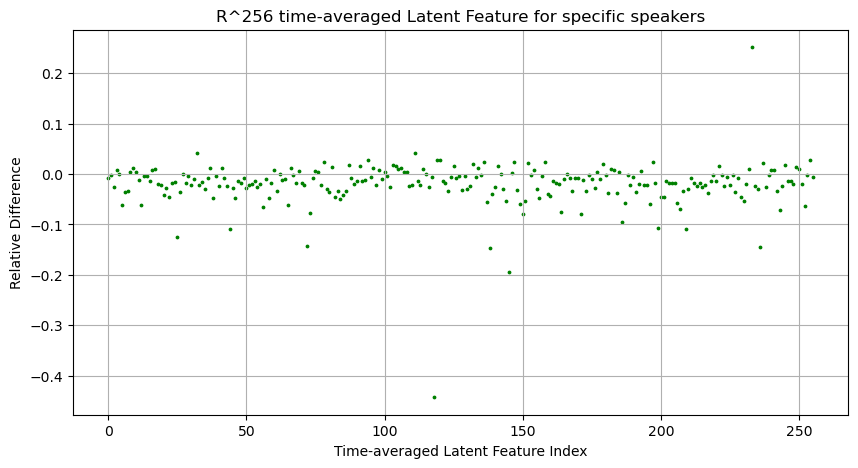

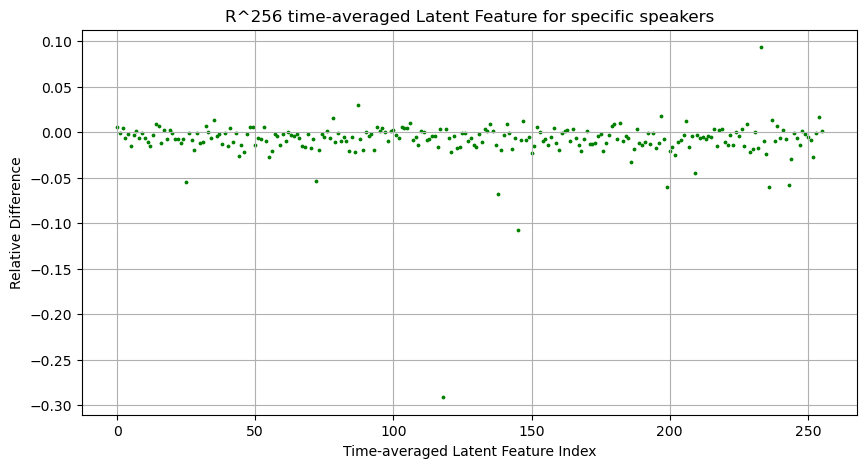

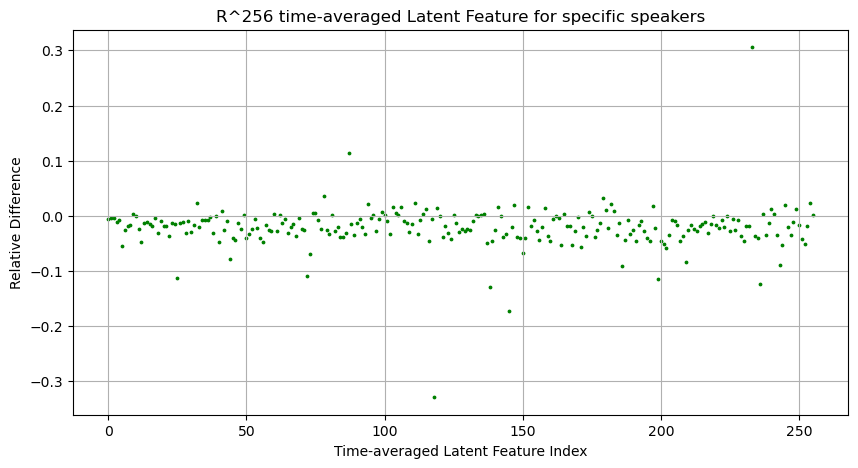

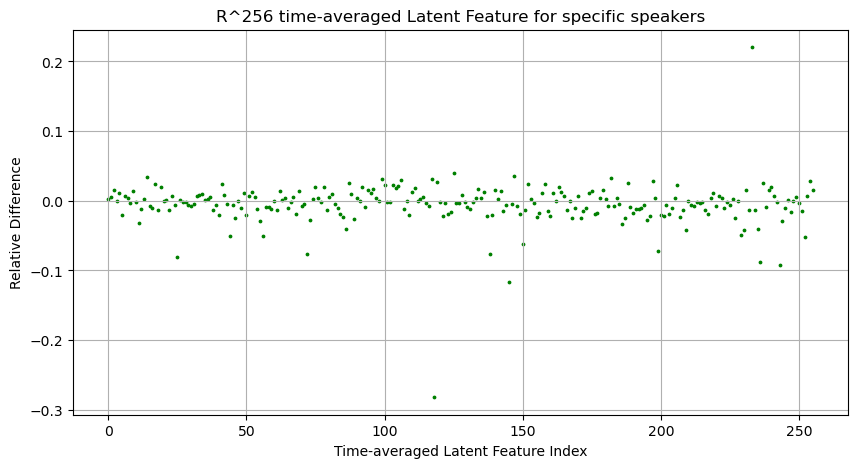

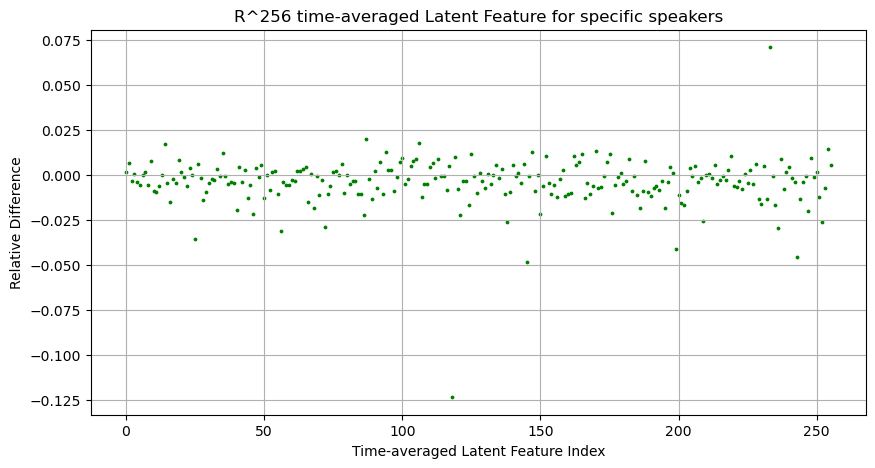

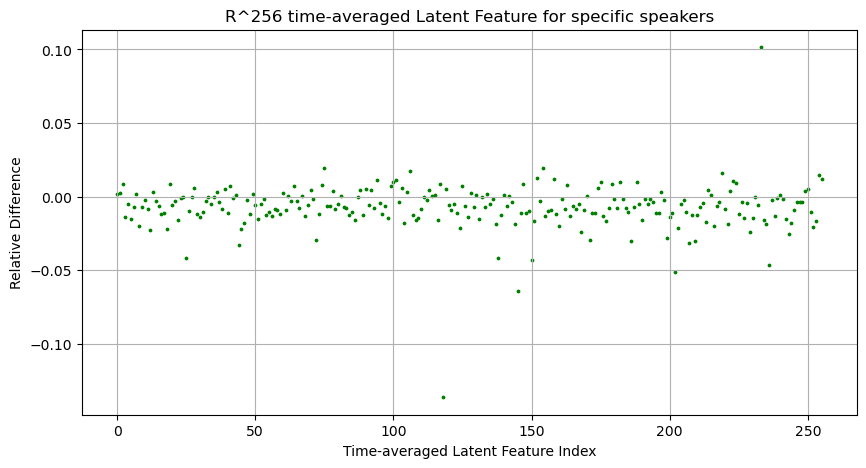

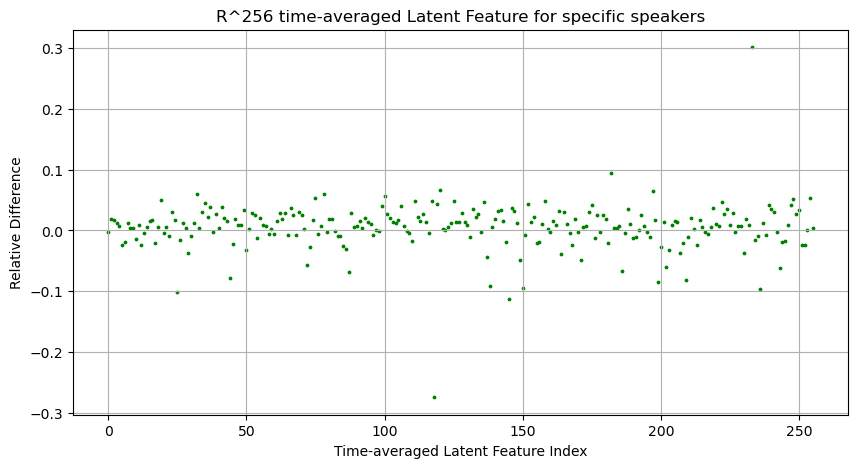

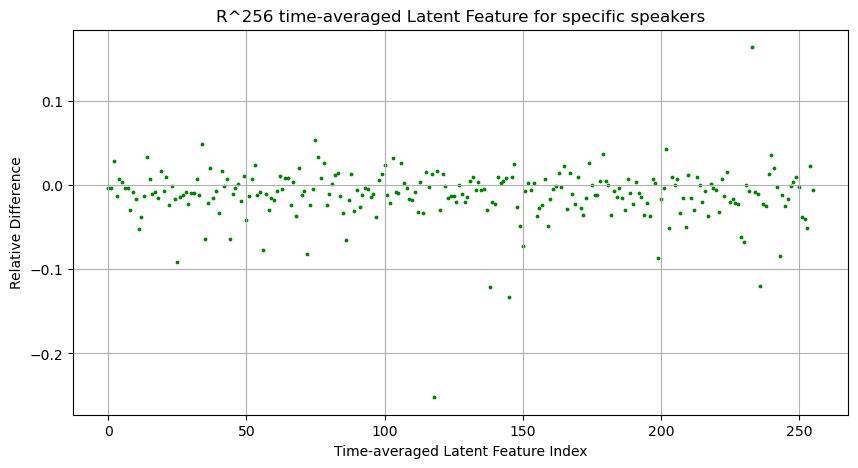

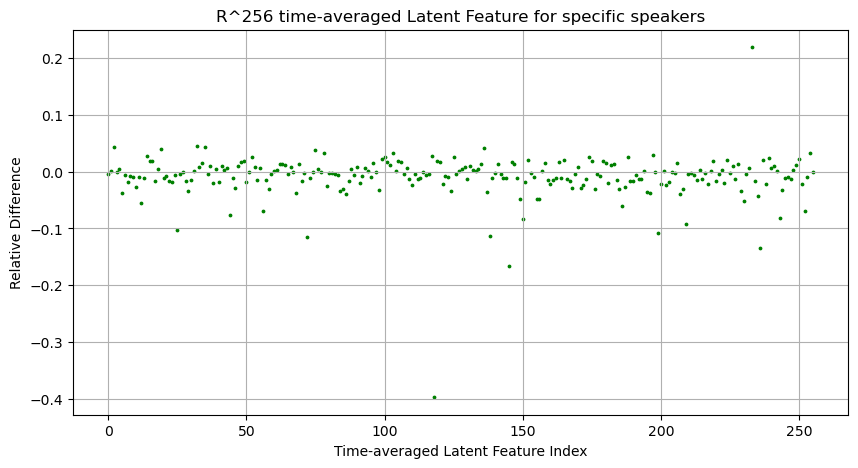

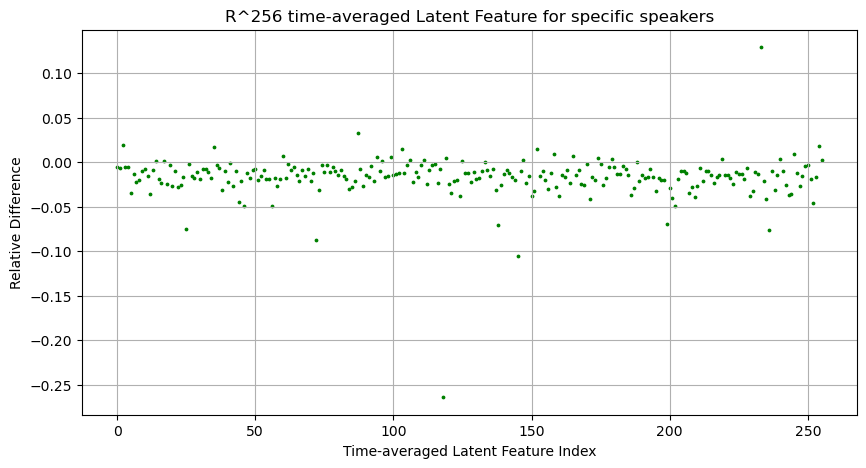

In [175]:
for i in range(10):
    plt.figure(figsize=(10, 5))  
    plot_latent_with_error_bars(np.mean(z_q12[i,:,:], axis=1) / np.mean(z_qmix[i,:,:], axis=1) - 1.0, color='green', ecolor='lightgreen', label='')
    # Add labels and title
    plt.xlabel('Time-averaged Latent Feature Index')
    plt.ylabel('Relative Difference')
    plt.title('R^256 time-averaged Latent Feature for specific speakers')
    plt.grid(True)
    plt.show()

No handles with labels found to put in legend.


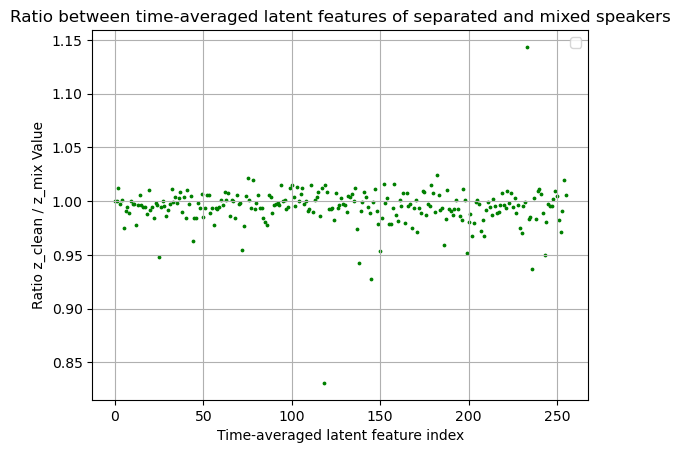

In [147]:
def plot_timeaveraged_latent(sep_latents: np.array, mixed_latents: np.array):
    # Compute the mean and standard deviation along axis 0
    sep_latents_mean = np.mean(sep_latents, axis=(0,2))
    mixed_latents_mean = np.mean(mixed_latents, axis=(0,2))
    
    # Create a scatter plot with the mean values
    x = np.arange(sep_latents_mean.shape[0])
    plt.scatter(x, sep_latents_mean/mixed_latents_mean, s=3, color='green')
    
    plt.title(f'Ratio between time-averaged latent features of separated and mixed speakers')
    # Add labels and title
    plt.xlabel('Time-averaged latent feature index')
    plt.ylabel('Ratio z_clean / z_mix Value')
    plt.legend()
    plt.grid(True)
    plt.show()
    # Add error bars to represent the standard deviation
    #plt.fill_between(x, latents_mean - latents_std, latents_mean + latents_std, color=ecolor, alpha=0.5)
    #plt.errorbar(x, latents_mean, yerr=latents_std, fmt='o', color=ecolor, ecolor=ecolor, elinewidth=2, capsize=2)
    

plot_timeaveraged_latent(np.concatenate([z_q1, z_q2], axis=0), z_qmix)

**Timbre latent analysis**

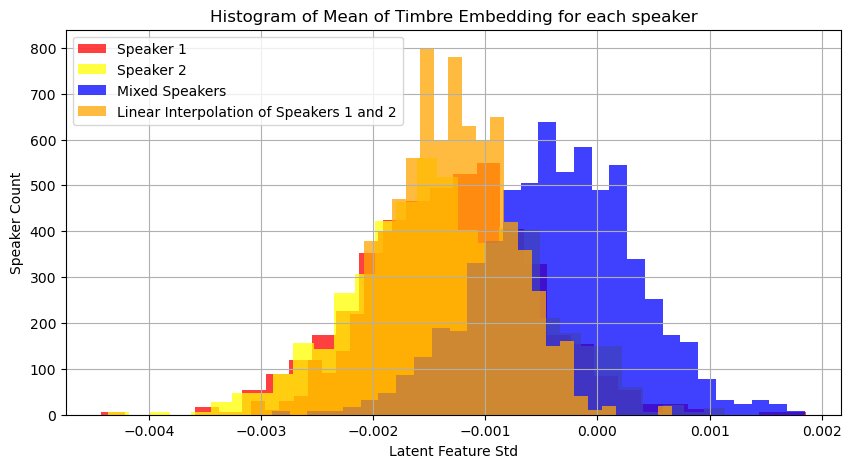

In [157]:
def plot_timbre_latent(spk_emb: np.array, label, color):
    spk_emb_mean = np.mean(spk_emb, axis=1)
    plt.hist(spk_emb_mean, bins=30, alpha=0.75, color=color, label=label, density=True)

plt.figure(figsize=(10, 5))
plot_timbre_latent(spk_emb_1, "Speaker 1", color='red')
plot_timbre_latent(spk_emb_2, "Speaker 2", color = 'yellow')
plot_timbre_latent(spk_emb_mix, "Mixed Speakers", color = 'blue')
plot_timbre_latent((spk_emb_1 + spk_emb_2) / 2, "Linear Interpolation of Speakers 1 and 2", color='orange')
plt.title(f'Histogram of Mean of Timbre Embedding for each speaker')
plt.xlabel('Latent Feature Std')
plt.ylabel('Speaker Count')
plt.grid(True)
plt.legend()
plt.show()

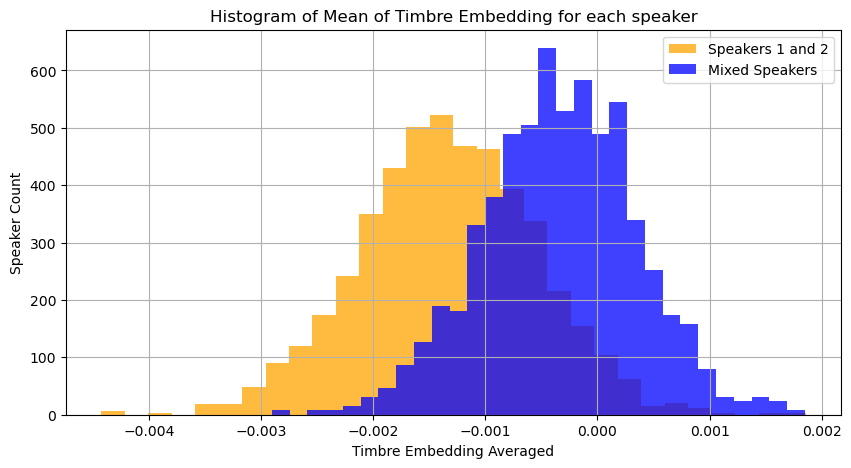

In [158]:
plt.figure(figsize=(10, 5))
plot_timbre_latent(np.concatenate([spk_emb_1, spk_emb_2]), "Speakers 1 and 2", color='orange')
plot_timbre_latent(spk_emb_mix, "Mixed Speakers", color = 'blue')

plt.title(f'Histogram of Mean of Timbre Embedding for each speaker')
plt.xlabel('Timbre Embedding Averaged')
plt.ylabel('Speaker Count')
plt.grid(True)
plt.legend()
plt.show()

Conclusion: We can separate the speakers when the feature maps are being conditioned on the speaker embeddings !

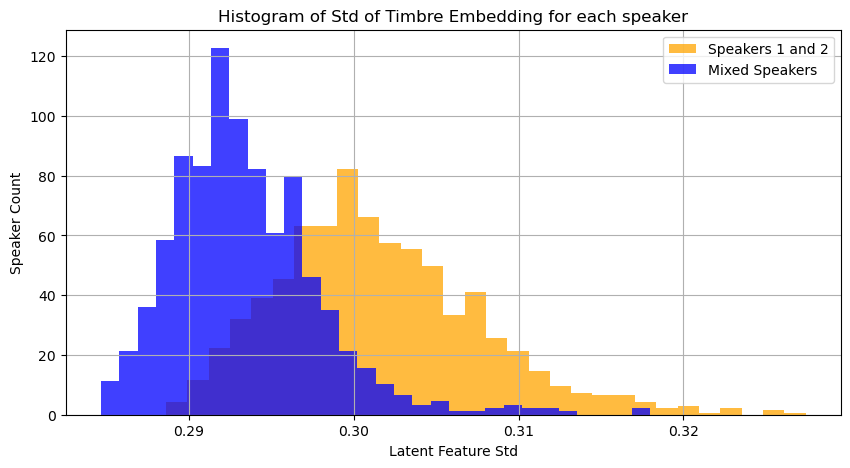

In [172]:
def plot_timbre_latent_with_error_bars(emb: np.array, label, color):
    emb_std = np.std(emb, axis = 1)
    plt.hist(emb_std, bins=30, alpha=0.75, color=color, label=label, density=True)
    

plt.figure(figsize=(10, 5))
plot_timbre_latent_with_error_bars(np.concatenate([spk_emb_1,spk_emb_2], axis=0), "Speakers 1 and 2", color='orange')
plot_timbre_latent_with_error_bars(spk_emb_mix, "Mixed Speakers", color ='blue')
plt.title(f'Histogram of Std of Timbre Embedding for each speaker')
plt.xlabel('Latent Feature Std')
plt.ylabel('Speaker Count')
plt.grid(True)
plt.legend()
plt.show()

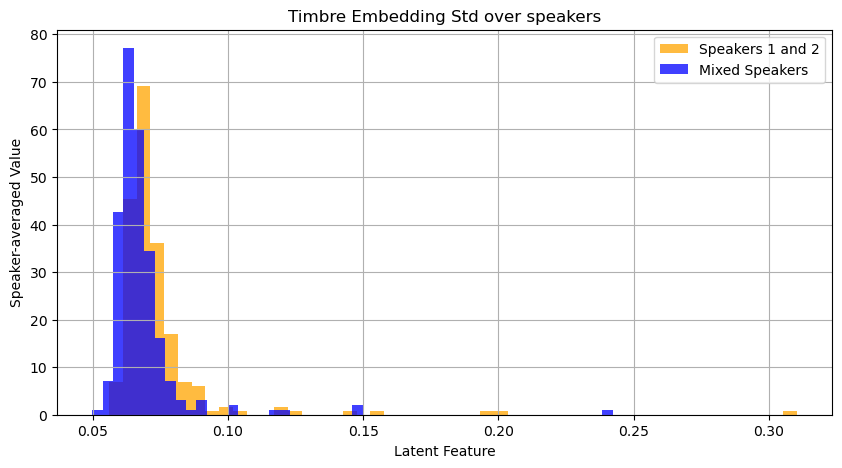

In [178]:
def plot_timbre_latent_spkavg(spk_emb: np.array, label, color):
    spk_emb_mean = np.std(spk_emb, axis=0)
    plt.hist(spk_emb_mean, bins=50, alpha=0.75, color=color, label=label, density=True)

plt.figure(figsize=(10, 5))
plot_timbre_latent_spkavg(np.concatenate([spk_emb_1,spk_emb_2], axis=0), "Speakers 1 and 2", color='orange')
plot_timbre_latent_spkavg(spk_emb_mix, "Mixed Speakers", color = 'blue')
plt.title(f'Timbre Embedding Std over speakers')
plt.xlabel('Latent Feature')
plt.ylabel('Speaker-averaged Value')
plt.grid(True)
plt.legend()
plt.show()

**What are the distributions for specific speaker instances when averageing about the fixed-dimensional latent direction? If we average over processed time bands:**

**How to do Latent diffusion to improve performance?**

Consider the possibilities that I propose here for the research:
1. Baseline: DiffSep framework
2. Pretrained FACodec + R^256 - averaged latent into DiffSep framework
3. Add "timber encoding" by learned linear projection
4. Conditioning based on latent vector with cross-attention
5. Diffusion Transformer as described in the first 2 meetings. We can experiment with (3) encoding, scaled-linear conditioning, or cross attention module. Exact backbone architecture to be analyzed later.

**T-SNE Analysis of timber embeddings**

In [215]:
%matplotlib inline

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f02ec327310>
Traceback (most recent call last):
  File "/home/eduardburlacu/miniconda3/envs/fedprox/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/eduardburlacu/miniconda3/envs/fedprox/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/eduardburlacu/miniconda3/envs/fedprox/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/eduardburlacu/miniconda3/envs/fedprox/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'


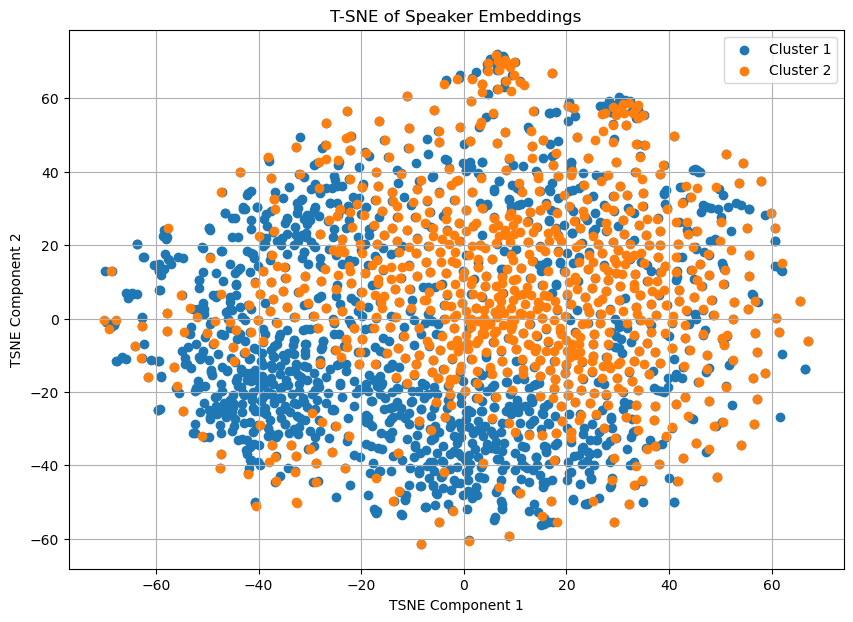

In [216]:
from sklearn.manifold import TSNE
# Assuming your arrays are named array1, array2, and array3
# Combine the arrays
combined_array = np.concatenate([spk_emb_1, spk_emb_2, spk_emb_mix], axis=0)

# Create labels
labels = np.array([0]*spk_emb_1.shape[0] + [0]*spk_emb_2.shape[0] + [1]*spk_emb_mix.shape[0])

# Apply T-SNE
tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(combined_array)

# Plot the results
plt.figure(figsize=(10, 7))
for label in np.unique(labels):
    indices = labels == label
    plt.scatter(tsne_results[indices, 0], tsne_results[indices, 1], label=f'Cluster {label+1}')

plt.title('T-SNE of Speaker Embeddings')
plt.xlabel('TSNE Component 1')
plt.ylabel('TSNE Component 2')
plt.legend()
plt.grid(True)
plt.show()


In [217]:
# Create a DataFrame for Plotly
import pandas as pd
import plotly.express as px

# Apply T-SNE
tsne = TSNE(n_components=3, random_state=42)
tsne_results = tsne.fit_transform(combined_array)

df = pd.DataFrame(tsne_results, columns=['TSNE Component 1', 'TSNE Component 2', 'TSNE Component 3'])
df['Cluster'] = labels


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f02ec327940>
Traceback (most recent call last):
  File "/home/eduardburlacu/miniconda3/envs/fedprox/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/eduardburlacu/miniconda3/envs/fedprox/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/eduardburlacu/miniconda3/envs/fedprox/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/eduardburlacu/miniconda3/envs/fedprox/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'


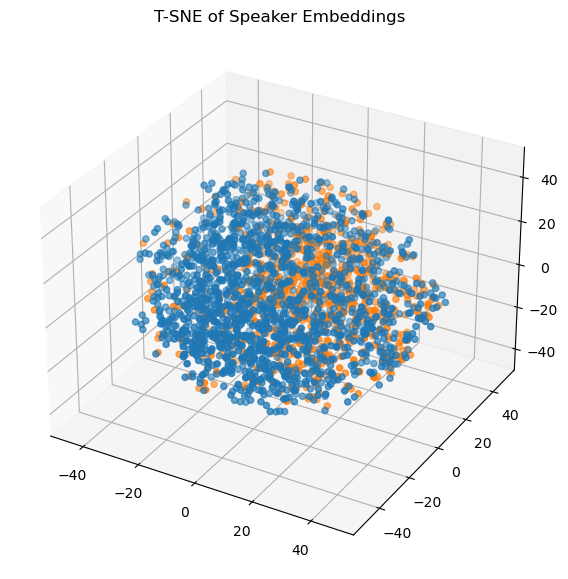

In [218]:
from mpl_toolkits.mplot3d import Axes3D


# Create a 3D scatter plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Plot each cluster with a different color
for label in np.unique(labels):
    indices = labels == label
    ax.scatter(tsne_results[indices, 0], tsne_results[indices, 1], tsne_results[indices, 2], label=f'Cluster {label+1}')

plt.title('T-SNE of Speaker Embeddings')
plt.show()